<a href="https://colab.research.google.com/github/AACRobinson/IMLO-Assessment/blob/main/IMLO_Assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Initialisation**

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import scipy.io
import sklearn

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import Compose, ToTensor, Resize, InterpolationMode
from torch import nn
from torch.utils.data import DataLoader


if torch.cuda.is_available() :
  torch.cuda.empty_cache()
  device = 'cuda'
elif torch.backends.mps.is_available() :
  torch.backends.mps.empty_cache()
  device = 'mps'
else:
  device = 'cpu'

print("Using", device, "device\n")


trainFlowers = datasets.Flowers102 (
    root="data",
    split="train",
    download=True,
    transform=transforms.Compose([ToTensor(), Resize((500, 500))]) #Need to convert all images to the same tensor dimensions
                                                          ##we want these images to be large enough to for model to be able to classify with a reasonable degree of accuracy
                                                          ##yet small enough to make sure memory doesn't fill up/model trains in a reasonable amount of time
)

validateFlowers = datasets.Flowers102 (
    root="data",
    split="val",
    download=True,
    transform=transforms.Compose([ToTensor(), Resize((500, 500))])
)

testFlowers = datasets.Flowers102 (
    root="data",
    split="test",
    download=True,
    transform=transforms.Compose([ToTensor(), Resize((500, 500))])
)

trainDataLoader = DataLoader(trainFlowers, batch_size=4, shuffle=True)
validateDataLoader = DataLoader(validateFlowers, batch_size=4, shuffle=True)
testDataLoader = DataLoader(testFlowers, batch_size=4, shuffle=True)

Using cuda device



# **Visualisation**

In [2]:
def showImage(dataloader) :
  train_features, train_labels = next(iter(dataloader))
  print("Feature batch shape: ", train_features.size())
  print("Labels batch shape: ", train_labels.size())
  image = train_features[0].squeeze().T #Need to transpose the tensor for the dimensions to be correct (3, 500, 500) -> (500, 500, 3)
  label = train_labels[0].item()
  plt.imshow(image)
  plt.show()
  print("Label: ", label)


def showGrid(dataset) :
  figure = plt.figure(figsize=(8, 8))
  cols, rows = 3, 3
  for i in range(1, cols*rows+1) :
    sample_index = torch.randint(len(dataset), size=(1,)).item()
    image, label = dataset[sample_index]
    figure.add_subplot(rows, cols, i)
    plt.title(dataset[sample_index][1])
    plt.axis("off")
    plt.imshow(image.squeeze().T)
  plt.show()

# **Building the NN - Initial Model 1, ~18% Accuracy**

In [ ]:
class flowerNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3*500*500, 1024), #About as large as is possible
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 102)
        )

    def forward(self, x):
        x = self.flatten(x).to(device)
        logits = self.linear_relu_stack(x).to(device)
        return logits

flowerNNModel = flowerNN().to(device)
modelLR = 0.0001
epochs = 120
lossFunct = nn.CrossEntropyLoss().to(device)
modelOptimiser = torch.optim.SGD(flowerNNModel.parameters(), modelLR)
plotTrainingLoss = []
plotValidationLoss = []
plotAccuracy = []
plotEpochs = np.arange(1, epochs)

def trainer(dataloader, nnModel, lossFunct, modelOptimiser) :
  nnModel.train()
  for modelBatch, (X, y) in enumerate(dataloader) :
    prediction = nnModel(X)
    y = y.to(device)
    loss = lossFunct(prediction, y)
    loss.backward()
    modelOptimiser.step()
    modelOptimiser.zero_grad()
  loss = loss.item()
  print("Training Loss: ", round(loss, 2))
  plotTrainingLoss.append(round(loss, 2))

def evaluator(dataloader, nnModel, lossFunct):
    nnModel.eval()
    dataSize = len(dataloader.dataset)
    numBatches = len(dataloader)
    loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            prediction = nnModel(X)
            y = y.to(device)
            loss += lossFunct(prediction, y).item()
            correct += (prediction.argmax(1) == y).type(torch.float).sum().item()

    loss /= numBatches
    correct /= dataSize
    print("Validation Loss: ", round(loss, 2), "\nAccuracy: ", round((100*correct), 2), "\n")
    plotValidationLoss.append(round(loss, 2))
    plotAccuracy.append(round((100*correct), 2))

for t in range(epochs):
    print("Epoch ", t+1, "\n-------------------------------")
    trainer(trainDataLoader, flowerNNModel, lossFunct, modelOptimiser)
    evaluator(validateDataLoader, flowerNNModel, lossFunct)
print("Final Evaluation ", "\n-------------------------------")
evaluator(testDataLoader, flowerNNModel, lossFunct)
print("Done!\n\n")
plt.plot(plotTrainingLoss, plotEpochs, color="blue")
plt.plot(plotValidationLoss, plotEpochs, color="green")
plt.plot(plotAccuracy, plotEpochs, color="red")
plt.show()

Epoch  1 
-------------------------------
Training Loss:  4.62
Validation Loss:  4.62 
Accuracy:  1.08 

Epoch  2 
-------------------------------


KeyboardInterrupt: 

# **Initial Model 2 - Invalid**

Low accuracy caused by algorithm trying to classify into too many categories?


*   Split the dataset into smaller datasets with 5-10 types of flower each
*   Train each dataset individually, average result



In [ ]:
def splitDataset(dataset, labelsPerSet) :
  splitSet = []
  currentSet = []
  increment = labelsPerSet

  print("Splitting Dataset...")
  for x in range(len(dataset)) :
    if dataset[x][1] < labelsPerSet :
      currentSet.append((dataset[x][0], (dataset[x][1]-(labelsPerSet-increment))))
    else :
      splitSet.append(currentSet)
      print("Set ", (labelsPerSet//increment), ":", (labelsPerSet-increment), "-", (labelsPerSet-1), "| Length: ", len(currentSet), "| Labels: ", (currentSet[-1][1]-currentSet[0][1])+1)
      labelsPerSet += increment
      currentSet = []
      currentSet.append((dataset[x][0], (dataset[x][1]-(labelsPerSet-increment))))

  splitSet.append(currentSet)
  print("Set ", (labelsPerSet//increment), ":", (labelsPerSet-increment), "-", (dataset[-1][1]), "| Length: ", len(currentSet), "| Labels: ", (currentSet[-1][1]-currentSet[0][1])+1)
  print("Done! \n")
  print()
  return splitSet

def DataLoaderPerSet(dataset, batch_size=16, shuffle=True) :
  dataloaders = []
  print("Initialising Dataloaders...")
  for item in dataset :
    dataloaders.append(DataLoader(item, batch_size, shuffle))
  print("Done! \n")
  return dataloaders


splitTrainFlowers = splitDataset(trainFlowers, 34) #HCF of 102 = 34 - Need all models to have the same number of different labels
splitValidateFlowers = splitDataset(validateFlowers, 34)
splitTestFlowers = splitDataset(testFlowers, 34)

splitTrainFlowersDataloaders = DataLoaderPerSet(splitTrainFlowers)
splitValidateFlowersDataloaders = DataLoaderPerSet(splitTrainFlowers)
splitTestFlowersDataloaders = DataLoaderPerSet(splitTrainFlowers)
print("Initialising Final Test Set...")
completeTestFlowersDataloader = DataLoader(testFlowers, batch_size=16, shuffle=True)
print("Done! \n")


class flowerNN(nn.Module):
    def __init__(self, labels):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3*250*250, 1024), #About as large as is possible
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, labels)
        )

    def forward(self, x):
        x = self.flatten(x).to(device)
        logits = self.linear_relu_stack(x).to(device)
        return logits

modelLR = 0.0001
epochs = 100
lossFunct = nn.CrossEntropyLoss().to(device)
modelArray = []
optimiserArray = []
print("Creating Test Models...")
for x in range(len(splitTrainFlowers)) :
  modelArray.append(flowerNN(splitTrainFlowers[-1][-1][1]-splitTrainFlowers[0][0][1]+1).to(device))
  optimiserArray.append(torch.optim.SGD(modelArray[x].parameters(), modelLR))
print("Done!")

Splitting Dataset...
Set  1 : 0 - 33 | Length:  340 | Labels:  34
Set  2 : 34 - 67 | Length:  340 | Labels:  34
Set  3 : 68 - 101 | Length:  340 | Labels:  34
Done! 


Splitting Dataset...
Set  1 : 0 - 33 | Length:  340 | Labels:  34
Set  2 : 34 - 67 | Length:  340 | Labels:  34
Set  3 : 68 - 101 | Length:  340 | Labels:  34
Done! 


Splitting Dataset...
Set  1 : 0 - 33 | Length:  1241 | Labels:  34
Set  2 : 34 - 67 | Length:  2138 | Labels:  34
Set  3 : 68 - 101 | Length:  2770 | Labels:  34
Done! 


Initialising Dataloaders...
Done! 

Initialising Dataloaders...
Done! 

Initialising Dataloaders...
Done! 

Initialising Final Test Set...
Done! 

Creating Test Models...
Done!


In [ ]:
print(splitTrainFlowers[-1][-1][1])
print(splitTrainFlowers[0][0][1])

for idx, batch in enumerate(completeTestFlowersDataloader) :
  print(batch[1])
  break
for item in splitTestFlowersDataloaders :
  for idx, batch in enumerate(item) :
    print(batch[1])
    break

5
0
tensor([ 69,  50,  46, 100,  88,   3,  91,   4,  49,  51,  77,  72,  83,   2,
         55,  93])
tensor([1, 6, 5, 4, 1, 3, 0, 0, 2, 2, 0, 0, 1, 6, 5, 4])
tensor([2, 0, 7, 0, 2, 7, 1, 0, 1, 5, 5, 7, 1, 1, 0, 5])
tensor([1, 0, 0, 3, 7, 2, 5, 7, 4, 1, 0, 5, 1, 3, 0, 5])
tensor([0, 4, 1, 2, 4, 4, 5, 1, 6, 0, 0, 6, 5, 3, 4, 4])
tensor([6, 2, 3, 7, 1, 7, 4, 3, 6, 5, 5, 7, 2, 2, 2, 3])
tensor([3, 0, 6, 0, 4, 2, 4, 7, 6, 5, 3, 7, 1, 4, 5, 5])
tensor([5, 6, 1, 7, 5, 3, 5, 5, 3, 7, 2, 6, 1, 0, 3, 2])
tensor([0, 1, 4, 1, 5, 4, 6, 0, 7, 0, 5, 3, 5, 7, 4, 3])
tensor([2, 0, 2, 2, 7, 7, 1, 7, 0, 7, 1, 0, 1, 4, 5, 4])
tensor([3, 3, 2, 1, 2, 5, 4, 5, 7, 0, 4, 4, 1, 0, 7, 4])
tensor([4, 7, 6, 1, 6, 2, 0, 6, 0, 1, 2, 4, 3, 4, 4, 7])
tensor([1, 4, 1, 1, 5, 3, 2, 5, 2, 2, 0, 4, 3, 0, 0, 6])
tensor([3, 3, 4, 1, 4, 1, 5, 0, 4, 0, 2, 4, 3, 5, 0, 1])


In [ ]:
def trainer(dataloader, nnModel, lossFunct, modelOptimiser) :
  nnModel.train()
  for modelBatch, (X, y) in enumerate(dataloader) :
    prediction = nnModel(X)
    y = y.to(device)
    loss = lossFunct(prediction, y)
    loss.backward()
    modelOptimiser.step()
    modelOptimiser.zero_grad()

def evaluator(dataloader, nnModel, lossFunct):
    nnModel.eval()
    dataSize = len(dataloader.dataset)
    numBatches = len(dataloader)
    loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            prediction = nnModel(X)
            y = y.to(device)
            loss += lossFunct(prediction, y).item()
            correct += (prediction.argmax(1) == y).type(torch.float).sum().item()

    loss /= numBatches
    correct /= dataSize
    loss = round(loss, 2)
    correct = round((100*correct), 2)

    print("Accuracy: ", correct, "\nAvg loss: ", loss, "\n")
    return (correct, loss)

modelResults = []
for i in range(len(splitTrainFlowersDataloaders)) :
  print("Training Set", i+1, ":\n-------------------------------")
  for j in range(epochs):
    trainer(splitTrainFlowersDataloaders[i], modelArray[i], lossFunct, optimiserArray[i])
    if j % 10 == 9 :
      print("Epoch ", j+1, "\n-------------------------------")
      evaluator(splitValidateFlowersDataloaders[i], modelArray[i], lossFunct)
  print("Set Evaluation ", "\n-------------------------------")
  modelResults.append(evaluator(splitTestFlowersDataloaders[i], modelArray[i], lossFunct))
print("Final Evaluation ", "\n-------------------------------")
finalAccuracy = 0
finalLoss = 0
for i in range(len(modelResults)) :
  finalAccuracy += modelResults[i][0]
  finalLoss += modelResults[i][1]
finalAccuracy /= len(modelResults)
finalLoss /= len(modelResults)
finalAccuracy = round(finalAccuracy, 2)
finalLoss = round(finalLoss, 2)
print("Accuracy: ", finalAccuracy, "\nAvg loss: ", finalLoss, "\n")
print("Done!\n\n")

Training Set 1 :
-------------------------------
Epoch  10 
-------------------------------
Accuracy:  21.47 
Avg loss:  3.47 

Epoch  20 
-------------------------------
Accuracy:  21.47 
Avg loss:  3.42 

Epoch  30 
-------------------------------
Accuracy:  29.41 
Avg loss:  3.37 

Epoch  40 
-------------------------------
Accuracy:  31.76 
Avg loss:  3.32 

Epoch  50 
-------------------------------
Accuracy:  35.29 
Avg loss:  3.26 

Epoch  60 
-------------------------------
Accuracy:  42.06 
Avg loss:  3.21 

Epoch  70 
-------------------------------
Accuracy:  45.0 
Avg loss:  3.15 

Epoch  80 
-------------------------------
Accuracy:  46.76 
Avg loss:  3.09 

Epoch  90 
-------------------------------
Accuracy:  48.24 
Avg loss:  3.02 

Epoch  100 
-------------------------------
Accuracy:  50.0 
Avg loss:  2.96 

Set Evaluation  
-------------------------------
Accuracy:  50.0 
Avg loss:  2.97 

Training Set 2 :
-------------------------------
Epoch  10 
------------------

# **Initial Model 3 - Using Pooling to Reformat Data**
*Parameters in form Image Size, batch Size, Learning Rate, Epochs*

Iteration 1 - Initial Algorithm - 50x50, 4, 0.001, 1000
*   Training time ~1h20m
*   Maximum Accuracy ~18%, Minimum Loss Function ~3.40 at epoch 120
*   Past this accuracy stagnates and loss function exponentially increases

---
Iteration 2 - Pooling to Reduce the Size of the Image - 500x500, 4, 0.001, 120
*   Training time ~25m
*   Maximum Accuracy ~11%, Minimum Loss Function ~3.6 at epoch 120





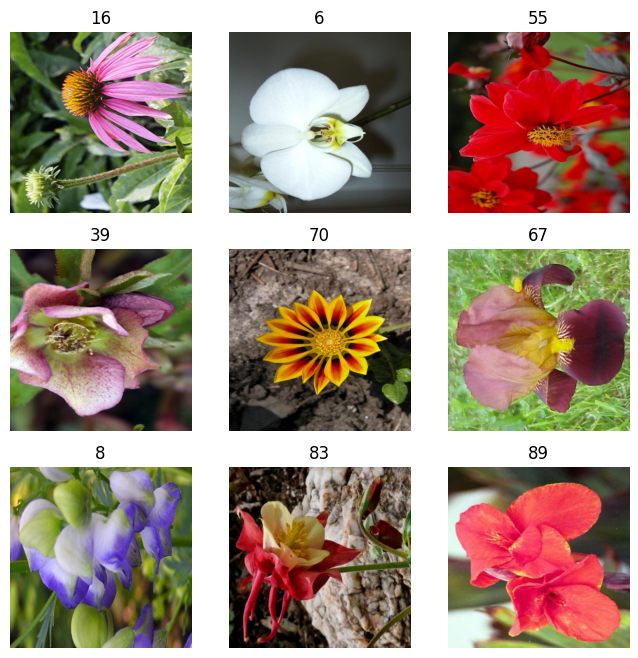

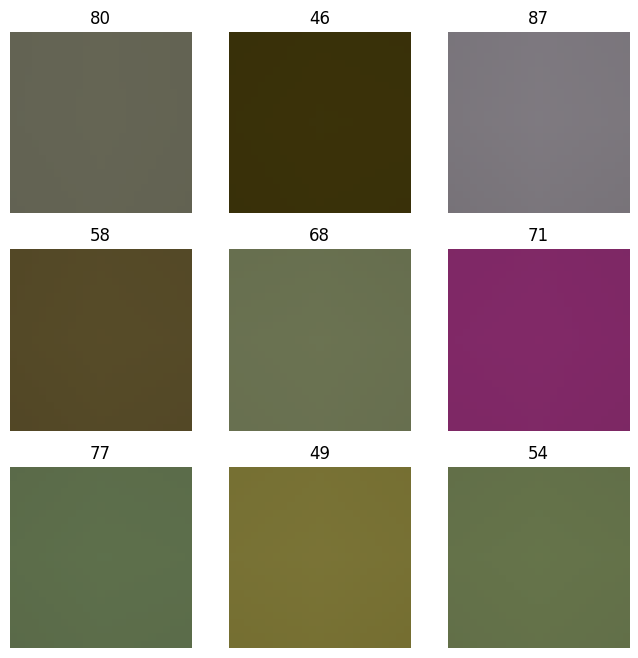

In [ ]:
trainFlowers = datasets.Flowers102 (
    root="data",
    split="train",
    download=True,
    transform=transforms.Compose([ToTensor(), Resize((500, 500))]) #Need to convert all images to the same tensor dimensions
                                                                    ##we want these images to be large enough to for model to be able to classify with a reasonable degree of accuracy
                                                                    ##yet small enough to make sure memory doesn't fill up/model trains in a reasonable amount of time
)

validateFlowers = datasets.Flowers102 (
    root="data",
    split="val",
    download=True,
    transform=transforms.Compose([ToTensor(), Resize((500, 500))])
)

testFlowers = datasets.Flowers102 (
    root="data",
    split="test",
    download=True,
    transform=transforms.Compose([ToTensor(), Resize((500, 500))])
)

#Define pooling function to preprocess data

poolFunction = nn.AvgPool2d((500, 500), stride=1, padding=12)
pooledTrainFlowers = pooledValidateFlowers = pooledTestFlowers = []

for x in range(len(trainFlowers)) :
  pooledTrainFlowers.append((poolFunction(trainFlowers[x][0]) , trainFlowers[x][1]))
for x in range(len(validateFlowers)) :
  pooledValidateFlowers.append((poolFunction(validateFlowers[x][0]), validateFlowers[x][1]))
for x in range(len(testFlowers)) :
  pooledTestFlowers.append((poolFunction(testFlowers[x][0]), testFlowers[x][1]))

showGrid(trainFlowers)
showGrid(pooledTrainFlowers)

In [ ]:
trainDataLoader = DataLoader(trainFlowers, batch_size=16, shuffle=True)
train_features, train_labels = next(iter(trainDataLoader))
print("Feature batch shape: ", train_features.size())
print("Labels batch shape: ", train_labels.size())

trainDataLoader = DataLoader(pooledTrainFlowers, batch_size=16, shuffle=True)
validateDataLoader = DataLoader(pooledValidateFlowers, batch_size=16, shuffle=True)
testDataLoader = DataLoader(pooledTestFlowers, batch_size=16, shuffle=True)

train_features, train_labels = next(iter(trainDataLoader))
print("Feature batch shape: ", train_features.size())
print("Labels batch shape: ", train_labels.size())

tensor([[[0.0353, 0.0358, 0.0402,  ..., 0.5670, 0.5600, 0.5593],
         [0.0392, 0.0392, 0.0406,  ..., 0.5670, 0.5600, 0.5593],
         [0.0510, 0.0435, 0.0427,  ..., 0.5652, 0.5591, 0.5632],
         ...,
         [0.0853, 0.0959, 0.1015,  ..., 0.4732, 0.4707, 0.4627],
         [0.0878, 0.0955, 0.0980,  ..., 0.4667, 0.4654, 0.4627],
         [0.0892, 0.0968, 0.0953,  ..., 0.4610, 0.4606, 0.4627]],

        [[0.0745, 0.0776, 0.0833,  ..., 0.4093, 0.3898, 0.3725],
         [0.0784, 0.0811, 0.0837,  ..., 0.4093, 0.3898, 0.3725],
         [0.0824, 0.0828, 0.0859,  ..., 0.4075, 0.3889, 0.3765],
         ...,
         [0.1912, 0.2018, 0.2074,  ..., 0.3792, 0.3701, 0.3569],
         [0.1936, 0.2014, 0.2039,  ..., 0.3727, 0.3648, 0.3569],
         [0.1951, 0.2026, 0.2012,  ..., 0.3670, 0.3600, 0.3569]],

        [[0.0314, 0.0266, 0.0257,  ..., 0.6124, 0.5894, 0.5765],
         [0.0353, 0.0300, 0.0261,  ..., 0.6081, 0.5884, 0.5765],
         [0.0392, 0.0318, 0.0283,  ..., 0.6055, 0.5832, 0.

In [ ]:
class flowerNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3*25*25, 128), #About as large as is possible
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 102),
        )

    def forward(self, x):
        x = self.flatten(x).to(device)
        logits = self.linear_relu_stack(x).to(device)
        return logits

flowerNNModel = flowerNN().to(device)
modelLR = 0.001
epochs = 120
lossFunct = nn.CrossEntropyLoss().to(device)
modelOptimiser = torch.optim.SGD(flowerNNModel.parameters(), modelLR)

def trainer(dataloader, nnModel, lossFunct, modelOptimiser) :
  nnModel.train()
  for modelBatch, (X, y) in enumerate(dataloader) :
    prediction = nnModel(X)
    y = y.to(device)
    loss = lossFunct(prediction, y)
    loss.backward()
    modelOptimiser.step()
    modelOptimiser.zero_grad()

def evaluator(dataloader, nnModel, lossFunct):
    nnModel.eval()
    dataSize = len(dataloader.dataset)
    numBatches = len(dataloader)
    loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            prediction = nnModel(X)
            y = y.to(device)
            loss += lossFunct(prediction, y).item()
            correct += (prediction.argmax(1) == y).type(torch.float).sum().item()

    loss /= numBatches
    correct /= dataSize
    print("Test Error: \n Accuracy: ", round((100*correct), 2), "\n Avg loss: ", round(loss, 2), "\n")

for t in range(epochs):
    trainer(trainDataLoader, flowerNNModel, lossFunct, modelOptimiser)
    if t % 10 == 0:
      print("Epoch ", t+1, "\n-------------------------------")
      evaluator(validateDataLoader, flowerNNModel, lossFunct)
print("Final Evaluation ", "\n-------------------------------")
evaluator(testDataLoader, flowerNNModel, lossFunct)
print("Done!\n\n")

Epoch  1 
-------------------------------
Test Error: 
 Accuracy:  1.48 
 Avg loss:  4.61 

Epoch  11 
-------------------------------
Test Error: 
 Accuracy:  3.07 
 Avg loss:  4.53 

Epoch  21 
-------------------------------
Test Error: 
 Accuracy:  3.76 
 Avg loss:  4.5 

Epoch  31 
-------------------------------
Test Error: 
 Accuracy:  5.56 
 Avg loss:  4.44 

Epoch  41 
-------------------------------
Test Error: 
 Accuracy:  5.59 
 Avg loss:  4.23 

Epoch  51 
-------------------------------
Test Error: 
 Accuracy:  6.29 
 Avg loss:  4.1 

Epoch  61 
-------------------------------
Test Error: 
 Accuracy:  6.75 
 Avg loss:  4.06 

Epoch  71 
-------------------------------
Test Error: 
 Accuracy:  6.59 
 Avg loss:  4.03 

Epoch  81 
-------------------------------
Test Error: 
 Accuracy:  8.27 
 Avg loss:  3.96 

Epoch  91 
-------------------------------
Test Error: 
 Accuracy:  9.72 
 Avg loss:  3.84 

Epoch  101 
-------------------------------
Test Error: 
 Accuracy:  10.5

In [ ]:
torch.save(flowerNNModel, "PoolModel")

# **Initial Model 4 - Taking Inspiration From LeNet5**

In [6]:
class flowerNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3*500*500, 3*32*32), #About as large as is possible
            nn.ReLU(),
            nn.MaxPool2d(3*32*32, 4),
            nn.Linear(3*16*16, 3*16*16),
            nn.ReLU(),
            nn.MaxPool2d(3*16*16, 4),
            nn.Linear(3*8*8, 102)
        )

    def forward(self, x):
        x = self.flatten(x).to(device)
        logits = self.linear_relu_stack(x).to(device)
        return logits

flowerNNModel = flowerNN().to(device)
modelLR = 0.0001
epochs = 120
lossFunct = nn.CrossEntropyLoss().to(device)
modelOptimiser = torch.optim.SGD(flowerNNModel.parameters(), modelLR)
plotTrainingLoss = []
plotValidationLoss = []
plotAccuracy = []
plotEpochs = np.arange(1, epochs)

def trainer(dataloader, nnModel, lossFunct, modelOptimiser) :
  nnModel.train()
  for modelBatch, (X, y) in enumerate(dataloader) :
    prediction = nnModel(X)
    y = y.to(device)
    loss = lossFunct(prediction, y)
    loss.backward()
    modelOptimiser.step()
    modelOptimiser.zero_grad()
  loss = loss.item()
  print("Training Loss: ", round(loss, 2))
  plotTrainingLoss.append(round(loss, 2))

def evaluator(dataloader, nnModel, lossFunct):
    nnModel.eval()
    dataSize = len(dataloader.dataset)
    numBatches = len(dataloader)
    loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            prediction = nnModel(X)
            y = y.to(device)
            loss += lossFunct(prediction, y).item()
            correct += (prediction.argmax(1) == y).type(torch.float).sum().item()

    loss /= numBatches
    correct /= dataSize
    print("Validation Loss: ", round(loss, 2), "\nAccuracy: ", round((100*correct), 2), "\n")
    plotValidationLoss.append(round(loss, 2))
    plotAccuracy.append(round((100*correct), 2))

for t in range(epochs):
    print("Epoch ", t+1, "\n-------------------------------")
    trainer(trainDataLoader, flowerNNModel, lossFunct, modelOptimiser)
    evaluator(validateDataLoader, flowerNNModel, lossFunct)
print("Final Evaluation ", "\n-------------------------------")
evaluator(testDataLoader, flowerNNModel, lossFunct)
print("Done!\n\n")
plt.plot(plotTrainingLoss, plotEpochs, color="blue")
plt.plot(plotValidationLoss, plotEpochs, color="green")
plt.plot(plotAccuracy, plotEpochs, color="red")
plt.show()

OutOfMemoryError: CUDA out of memory. Tried to allocate 8.58 GiB. GPU 0 has a total capacity of 14.75 GiB of which 3.07 GiB is free. Process 63847 has 11.68 GiB memory in use. Of the allocated memory 11.55 GiB is allocated by PyTorch, and 10.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)